# Note to self:

## draw histogram of each output for QLKNN and target to compare

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import glob
import json

from tqdm import tqdm

In [2]:
from scripts.QLKNN import QLKNN, QLKNNDataset
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
f = open("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_loss_epoch_vs_step_chart_data")
test_loss = json.load(f)
f.close()

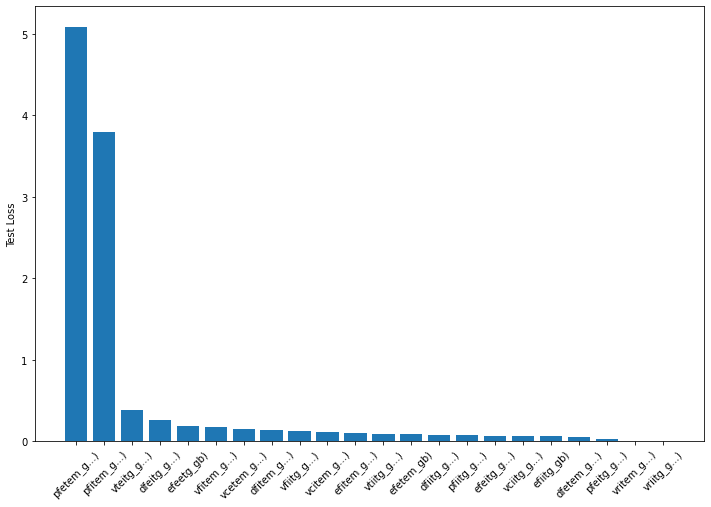

In [4]:
labels = []
out = []
for test in test_loss:
    experiment_name = test['name']
    x = experiment_name.split('-')
    labels.append(x[-1])
    out.append(test['y'][0])

x_points = np.arange(len(labels))

out = np.array(out)
sort_idx = np.argsort(np.array(out))[::-1]


out = out[sort_idx]

labels = np.array(labels)
labels = labels[sort_idx]

plt.figure(figsize = (12,8))
plt.bar(x_points, out)
plt.xticks(x_points, labels);
plt.xticks(rotation = 45);
plt.ylabel("Test Loss");

/tmp/ipykernel_40912/3492786188.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


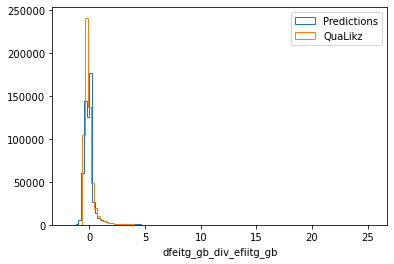

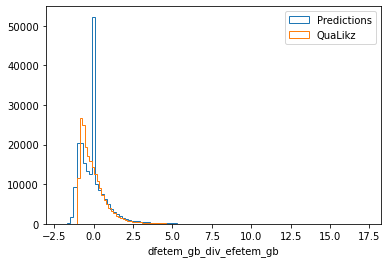

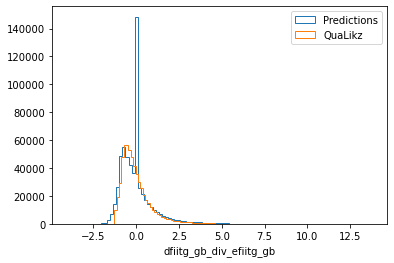

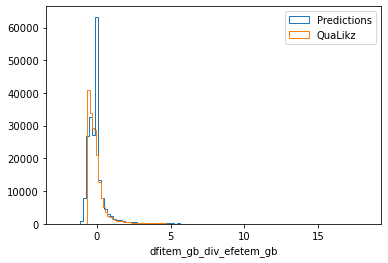

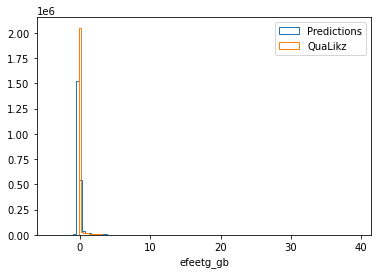

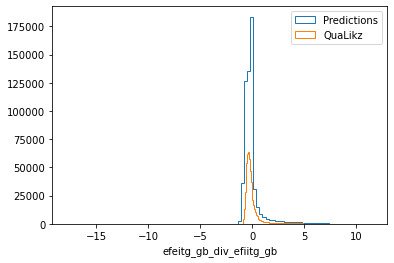

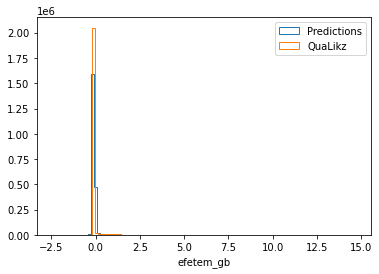

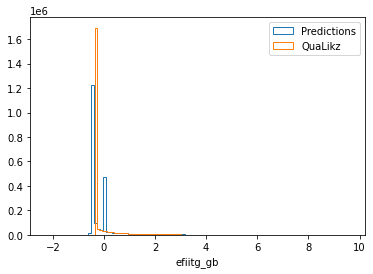

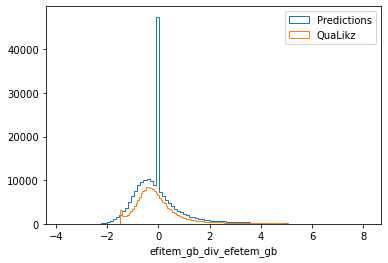

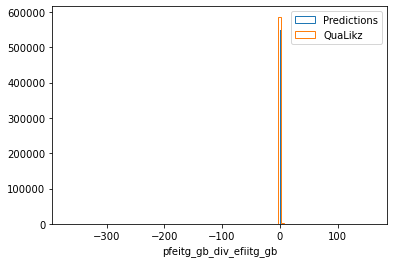

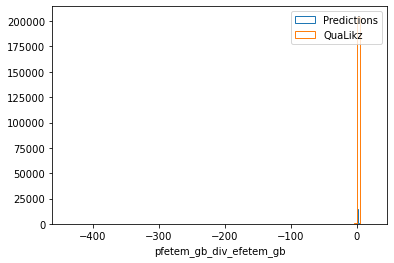

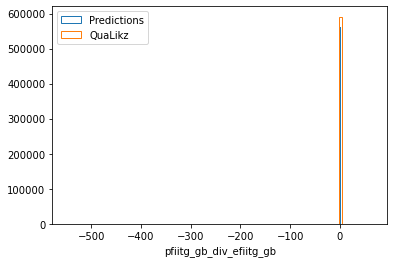

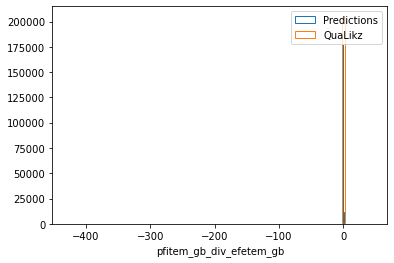

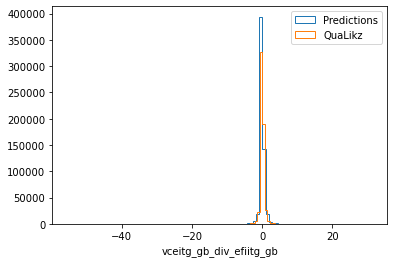

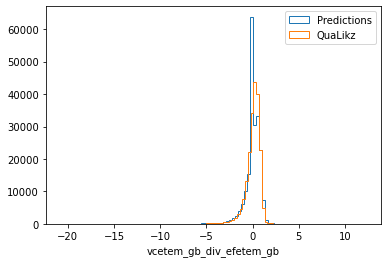

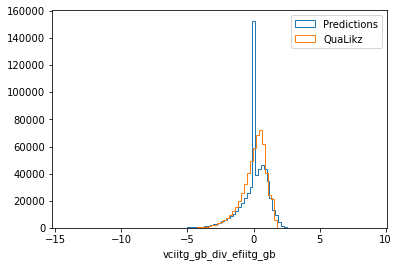

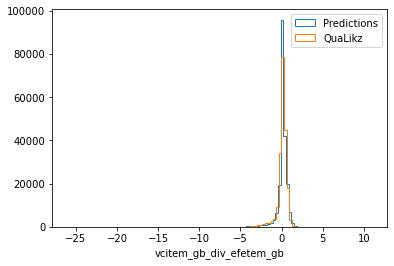

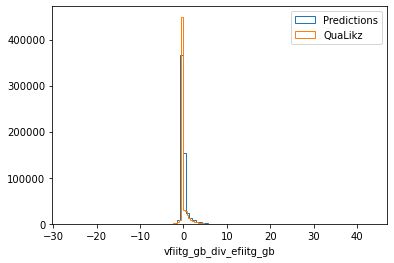

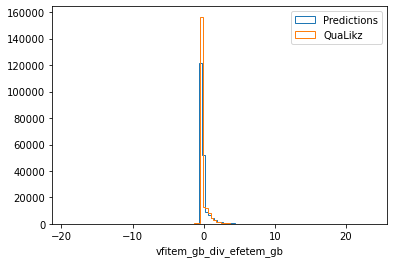

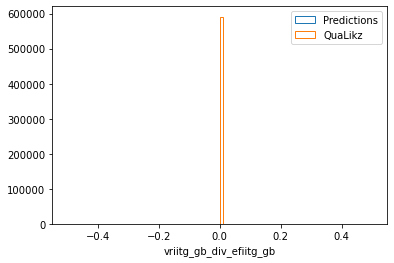

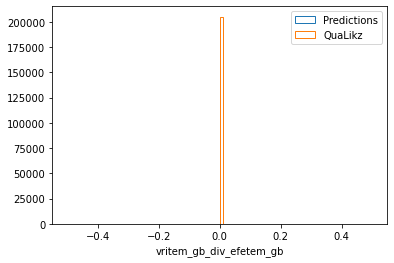

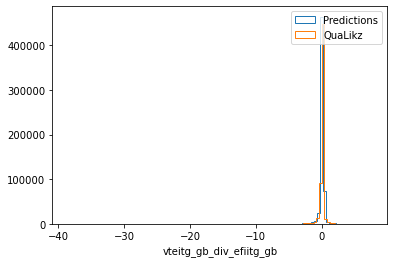

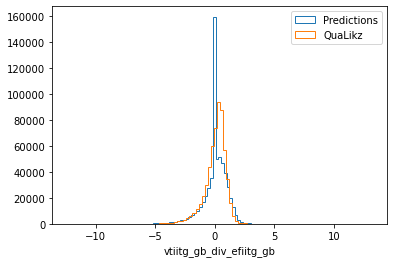

In [21]:
#test_data_path = "../../data/QLKNN_test_data.pkl"
test_data_path = "../../data/test_data_clipped.pkl"
train_data_path = "../../data/train_data_clipped.pkl"
predictions_list = []

for target in target_keys:
    path = glob.glob(f"../../logs/QLKNN-Regressor/Run-7-{target}/*.ckpt")[0]
    model = QLKNN.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 25, learning_rate = 0.002)
    
    train_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = True)
    train_data.scale()

    test_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = False)
    test_data.scale()

    test_loader = DataLoader(test_data, batch_size = 2048, shuffle = True, num_workers = 1)
    
    y = test_data.data[target]
    y = torch.tensor(y.values)
    X = test_data.data[train_keys]
    X = torch.tensor(X.values)
    
    predictions = model(X).detach().numpy()
    predictions_list.append(predictions)
    
    plt.figure()
    
    plt.hist(predictions, bins = 100, histtype = 'step',
             label = "Predictions",)# range = (predictions.min(), 6))
    plt.hist(test_data.data[target], bins = 100, histtype = 'step',
             label = "QuaLikz",)# range = (predictions.min(), 6))
    plt.xlabel(target)
    plt.legend()
    

In [8]:
predictions_numpy = predictions.squeeze()

random_variable = test_data.data[train_keys[3]].to_numpy()

predictions_dict = {'x': random_variable, 'y': predictions_numpy}
predictions_df = pd.DataFrame(data = predictions_dict)
predictions_df['type'] = 'QLKNN'

target_dict = {'x': random_variable, 'y': test_data.data[target]}
target_df = pd.DataFrame(data = target_dict)
target_df['type'] = 'target'

plot_df = pd.concat([predictions_df.sample(5_000), target_df.sample(5_000)], axis = 0, ignore_index = True)

plot_df

,x,y,type
0,-0.527691,0.551558,QLKNN
1,-0.527691,-0.000000,QLKNN
2,1.430159,1.153137,QLKNN
3,0.146616,-0.385514,QLKNN
4,-0.527691,-1.054697,QLKNN
...,...,...,...
9995,0.721251,0.373494,target
9996,-0.527691,-0.254297,target
9997,0.385421,0.220689,target
9998,-0.527691,-0.372493,target


In [ ]:
sns.jointplot(data = plot_df, x = 'x', y = 'y', hue = 'type', kind = 'kde')

In [9]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [10]:
#test_data_path = "../../data/QLKNN_test_data.pkl"
test_data_path = "../../data/valid_data_clipped.pkl"
train_data_path = "../../data/train_data_clipped.pkl"

df_train = pd.read_pickle(train_data_path)
df_train, scaler = ScaleData(df_train.sample(100_000))

n = 10_000
df_test = pd.read_pickle(test_data_path)
df_test, _ = ScaleData(df_test.sample(n), scaler)

In [ ]:
train_keys

Evaluating on dfeitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:06<00:00, 161.14it/s]


Evaluating on dfetem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:02<00:00, 397.58it/s]


Evaluating on dfiitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:08<00:00, 111.62it/s]


Evaluating on dfitem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:02<00:00, 365.12it/s]


Evaluating on efeetg_gb


100%|██████████| 1000/1000 [00:44<00:00, 22.40it/s]


Evaluating on efeitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:06<00:00, 162.99it/s]


Evaluating on efetem_gb


100%|██████████| 1000/1000 [00:27<00:00, 35.94it/s]


Evaluating on efiitg_gb


100%|██████████| 1000/1000 [00:23<00:00, 41.77it/s]


Evaluating on efitem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:02<00:00, 437.00it/s]


Evaluating on pfeitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:07<00:00, 139.42it/s]


Evaluating on pfetem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:02<00:00, 426.28it/s]


Evaluating on pfiitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:38<00:00, 25.74it/s]


Evaluating on pfitem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:03<00:00, 301.80it/s]


Evaluating on vceitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:08<00:00, 118.18it/s]


Evaluating on vcetem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:01<00:00, 522.35it/s]


Evaluating on vciitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:09<00:00, 102.09it/s]


Evaluating on vcitem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:01<00:00, 546.41it/s]


Evaluating on vfiitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:09<00:00, 100.13it/s]


Evaluating on vfitem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:01<00:00, 549.24it/s]


Evaluating on vriitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:14<00:00, 66.77it/s]


Evaluating on vritem_gb_div_efetem_gb


100%|██████████| 1000/1000 [00:10<00:00, 91.96it/s]
/tmp/ipykernel_40912/2912275996.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Evaluating on vteitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:09<00:00, 101.20it/s]


Evaluating on vtiitg_gb_div_efiitg_gb


100%|██████████| 1000/1000 [00:03<00:00, 277.65it/s]


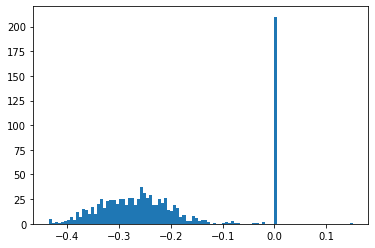

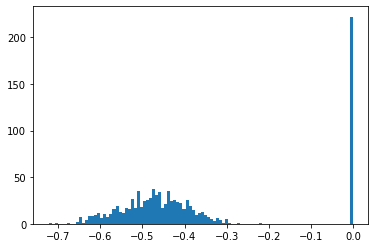

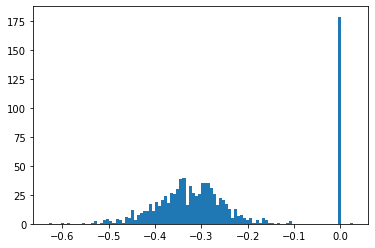

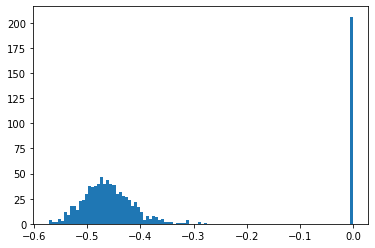

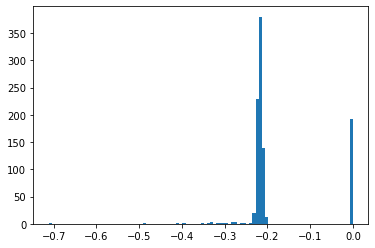

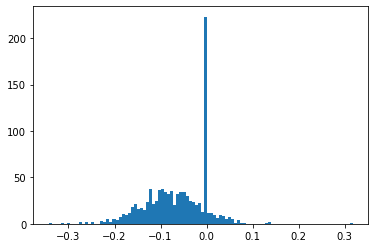

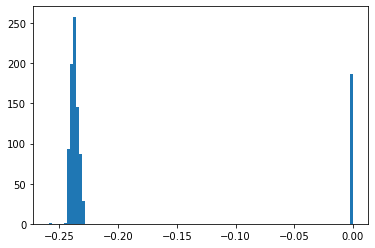

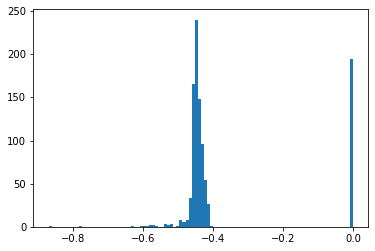

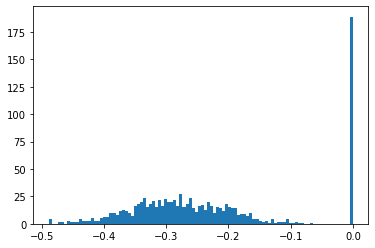

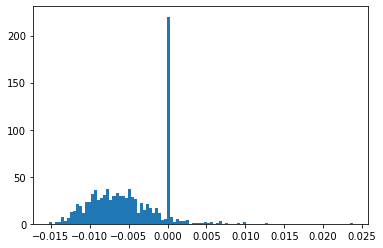

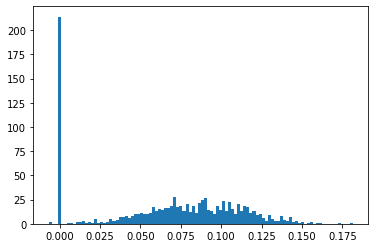

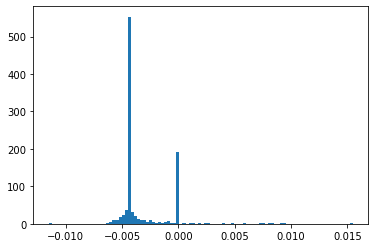

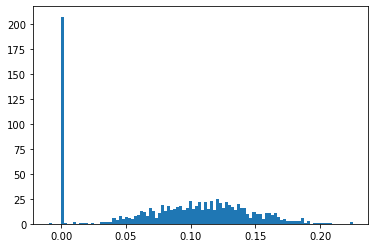

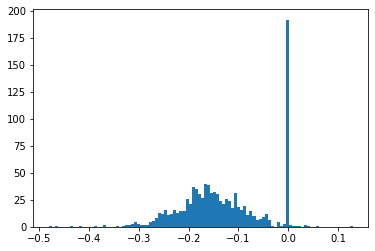

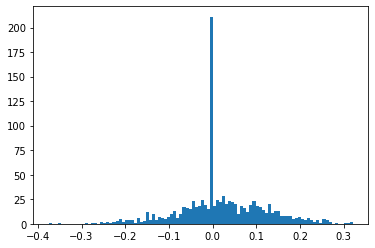

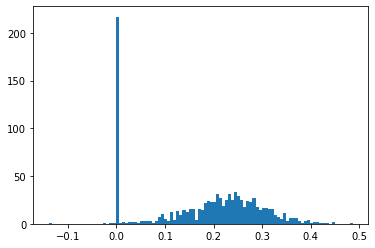

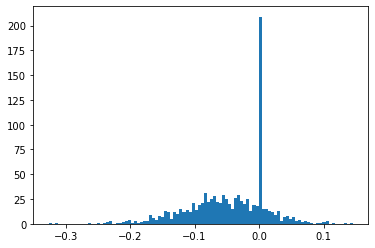

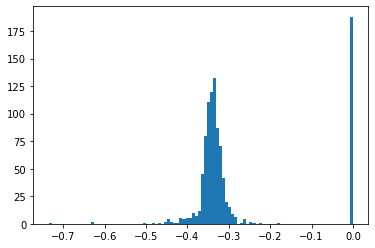

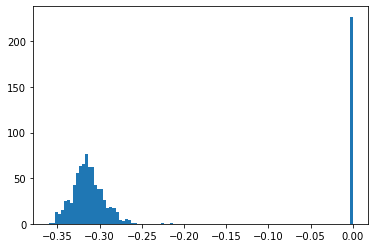

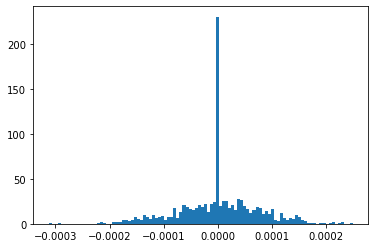

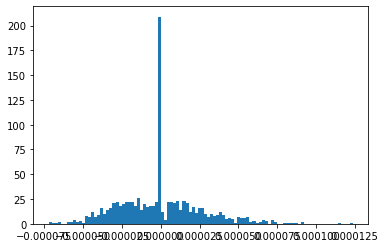

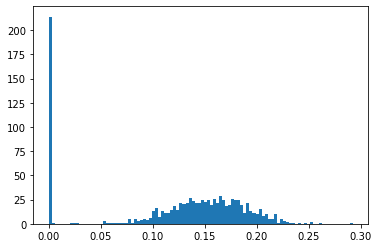

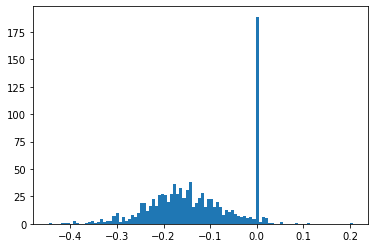

In [38]:
keys = []

target_dict = {}

for target in target_keys:
    print(f"Evaluating on {target}")
    path = glob.glob(f"../../logs/QLKNN-Regressor/Run-7-{target}/*.ckpt")[0]
    model = QLKNN.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 25, learning_rate = 0.002)
    
#     train_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = True)
#     train_data.scale()

#     test_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = False)
#     test_data.scale()

#     test_loader = DataLoader(test_data, batch_size = 2048, shuffle = True, num_workers = 1)

    test_data = df_test[train_keys + [target]]
    test_data = test_data.dropna()
    
    y = test_data[target]
    y = torch.tensor(y.values)
    X = test_data[train_keys]
    X = torch.tensor(X.values)
    
    eval_model = model.eval()
    enable_dropout(eval_model)
    
    #predictions = model(X).detach().numpy()
    #predictions_list.append(predictions)

    tmp_list = []
    tmp_tmp = []
    for _ in tqdm(range(1000)):
        output = eval_model(X)
        tmp_list.append(output)
        tmp_tmp.append(eval_model(X[0]).detach().numpy().flatten())
       
    plt.figure()
    plt.hist(np.array(tmp_tmp).flatten(), bins = 50);
        
    output_mean = torch.stack(tmp_list).mean(dim = 0)
    out_std = torch.stack(tmp_list).std(dim = 0)
    
    target_dict[target] = (output_mean, out_std)


# # test the model 100 times on each datapoint
# device = "cuda" if torch.cuda.is_available() else "cpu"
# test_loss = 0.0
# for data, target in val_loader:
#     data, target = data.to(device), target.to(device)

#     tmp_list = []
#     for _ in range(100):
#         output = eval_model(data)
#         tmp_list.append(output)

#     output = torch.stack(tmp_list).mean(dim=0)
#     test_loss += F.mse_loss(output, target, reduction='sum').item()  # sum up batch loss

#     output_variance = torch.stack(tmp_list).var(dim=0)      

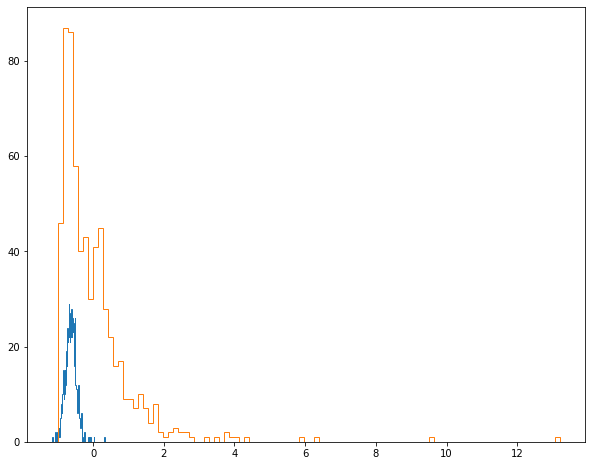

In [24]:
plt.figure(figsize = (10,8))

plt.hist(target_dict["dfetem_gb_div_efetem_gb"][0].detach().numpy(), bins = 100, histtype = "step");
plt.hist(df_test["dfetem_gb_div_efetem_gb"], bins = 100, histtype = "step");

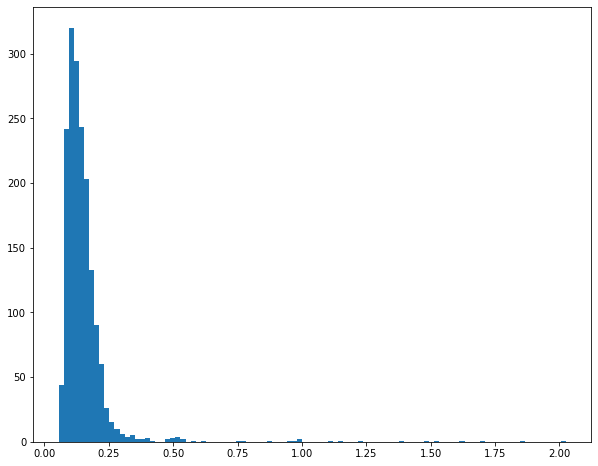

In [19]:
plt.figure(figsize = (10,8))

plt.hist(target_dict["dfeitg_gb_div_efiitg_gb"][1].detach().numpy(), bins = 100);

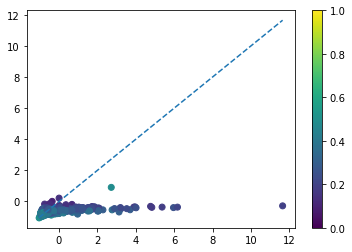

In [77]:
plt.figure()
plotting = "dfetem_gb_div_efetem_gb"

list_ = list(target_dict[plotting][1].detach().numpy().flatten())

x_ = np.linspace(df_test[plotting].min(), df_test[plotting].max(), 100)

plt.scatter(df_test[plotting].dropna(), target_dict[plotting][0].detach().numpy()
            , c = plt.cm.viridis(list_), s = None)
plt.colorbar()
plt.plot(x_, x_, "--")

In [6]:
class QLKNN(pl.LightningModule):
    """
    Class that implements QLKNN model as defined in the paper:
    Fast modeling of turbulent transport in fusion plasmas using neural networks
    """

    def __init__(
        self,
        n_input: int = 15,
        batch_size: int = 2048,
        epochs: int = 50,
        learning_rate: float = 0.001,
    ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Dropout(0.2),
        )
        self.lr = learning_rate

    def forward(self, x):
        X = self.model(x.float())
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
        return optimizer

    def step(self, batch, batch_idx):
        X, y = batch
        pred = self.forward(X).squeeze()
        loss = self.loss_function

        return loss(pred.float(), y.float())

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, sync_dist=True, logger=True
        )

    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        # tensorboad_logs = {'test_loss': loss}
        self.log(
            "test_loss", loss, on_step=True, on_epoch=True, sync_dist=True, logger=True
        )

    def loss_function(self, y, y_hat):
        # Loss function missing regularization term (to be added using Adam optimizer)
        lambda_stab = 1e-3
        k_stab = 5
        if y.sum() == 0:
            c_good = 0
            c_stab = torch.mean(y_hat - k_stab)

        else:
            c_good = torch.mean(torch.square(y - y_hat))
            c_stab = 0
        return c_good + lambda_stab * k_stab